# Activity 1 KNN

<img src="./tec_logo.png" width="auto" height="200" />

**Marcos Dayan Mann**

A01782876

Deliver date: August 26th, 2025


## Introduction

This Jupyter Notebook implements a KNN machine learning model for classifying between a person who suffers from a heart disease, depending on features such as vital signs, coelsterol and glucose levels, etc.

The dataset for training the model is built up by 303 samples, each one with 13 features represented by a numerical scale, and a binary tag for marking the sample wether as "Aucencia" or "Presencia" for any heart desease.

The strategy that I will perform will be:    
1. Split the dataset into training and testing samples
2. Create a custom KNN model with its helper methods such as for measuring similarity between vectors, running the training and tests, and measuring the outcome with graphs
3. Create a KNN model with sklearn
4. Create helper methods to orchestrate the training, run tests and measure the output of the model with graphs

## Install required dependencies

In [2]:
import sys
!{sys.executable} -m pip install scikit-learn numpy pandas plotly


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/bin/python -m pip install --upgrade pip


## Prepare training and testing dataset (HW point 1)

It is important to consider that this script will arrange the dataset into a different training and testing subset each time, because before splitting the data, this script shuffles it


In [2]:
import codecs
import random

lista=[]
with codecs.open("dataset.txt","r","UTF-8") as file:
    for line in file:
        elements=(line.strip('\n')).split(",")
        temp=[str(float(x)) for x in elements]
        if temp[-1]=="0.0":
            temp[-1]="Absence"
        else:    
            temp[-1]="Present"
        lista.append(temp)

random.shuffle(lista)

with codecs.open("training.txt","w","UTF-8") as file:
    for x in lista[:242]:
        file.write(",".join(x)+"\n")

with codecs.open("test.txt","w","UTF-8") as file:
    for x in lista[242:]:
        file.write(",".join(x)+"\n")    

## Euclidean distance function for computing the distance between vectors

In [3]:
import math

def euclidean_distance(v1, v2):
    sum_squared_differences = sum((x2-x1)**2 for x1, x2 in zip(v1, v2))
    return math.sqrt(sum_squared_differences) 

## Manhattan distance function for computing the distance between vectors (HW point 2)

I found out Manhattan distance gave better results than euclidean distance or cosine similarity for multidimensional vectors

In [4]:
def manhattan_distance(v1, v2) -> float:
    return sum(abs(x2 - x1) for x1, x2 in zip(v1, v2))

## Cosine similarity distance function for computing the distance between vectors (HW point 3)

In [5]:
import numpy as np

def cosine_similarity(v1, v2) -> float:
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    
    return dot_product / (norm_v1 * norm_v2)

## Classify function (KNN model)

In [6]:
from statistics import mode
from typing import List

def classify(test_vector: List, data_attributes: List[List], data_labels: List, k: int, distance_function = manhattan_distance) -> str:
    distances=[]
    for vector, label in zip(data_attributes,data_labels):
        distance = distance_function(vector,test_vector)
        distances.append((distance,label))
        
    distances.sort(key= lambda x: x[0])
    votelabels=[]
    
    for x in distances[:k]:
        votelabels.append(x[1])
        
    return mode(votelabels)

This classify function represents my custom KNN model.    
Basically the function takes as arguments a vector to classify, a list of vectors that represents the model training data, the labels corresponding to the training data, and the function for computing the vector similarity, that defaults to the manhattan distance, which i found as the best performer for multidimensional vectors.

The function iterates on the training data vectors and computes each one's distance related to the test vector, then appends the distance with its label into a list.

Then, it sorts the list based on the distance, and selects the k smallest distances labels, that correspond to the k most similar vectors to the test vector, and returns the most common label of the k vectors.

This algorithm has the advantage of being very easy to implement manually, and it performs almost as good as the sklearn KNN, but as long as the dataset remains small, because it is very inefficient and consumes a lot of memory, this does not allow this model to work with large datasets.

## Prepare samples function

In [8]:
from typing import Tuple

def prepare_samples(fileroute: str) -> Tuple[List, List]:
    vectors = []
    labels = []
    with codecs.open(fileroute,"r","UTF-8") as file:
        for line in file:
            elements=(line.rstrip('\n')).split(",")
            vectors.append([float(e) for e in elements[:-1]])
            labels.append(elements[-1])
    
    return vectors, labels

## Test analog KNN model with different K's to determine the best for this case (HW points 4, 5, 6)

In [9]:
from typing import Tuple

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")

def test_knn(training, training_labels, test, test_labels, k) -> Tuple[int, float]:
    correct_predictions = 0
    for vector, label in zip(test, test_labels):
        predicted = classify(vector, training, training_labels, k)
        if predicted == label:
            correct_predictions += 1

    print(f"k: {k}, correct_predictions: {correct_predictions}")

    print(f"model accuracy: {(correct_predictions/len(test))*100}")
    return k, correct_predictions


results = []
for k in range(3, 42):
    results.append(test_knn(training, training_labels, test, test_labels, k))

best_manual_k = max(results, key= lambda x: x[1])

print(f"\nKNN best manual k: {best_manual_k[0]}, correct predictions: {best_manual_k[1]}")    

k: 3, correct_predictions: 43
model accuracy: 70.49180327868852
k: 4, correct_predictions: 45
model accuracy: 73.77049180327869
k: 5, correct_predictions: 45
model accuracy: 73.77049180327869
k: 6, correct_predictions: 48
model accuracy: 78.68852459016394
k: 7, correct_predictions: 47
model accuracy: 77.04918032786885
k: 8, correct_predictions: 47
model accuracy: 77.04918032786885
k: 9, correct_predictions: 47
model accuracy: 77.04918032786885
k: 10, correct_predictions: 47
model accuracy: 77.04918032786885
k: 11, correct_predictions: 45
model accuracy: 73.77049180327869
k: 12, correct_predictions: 46
model accuracy: 75.40983606557377
k: 13, correct_predictions: 43
model accuracy: 70.49180327868852
k: 14, correct_predictions: 44
model accuracy: 72.1311475409836
k: 15, correct_predictions: 43
model accuracy: 70.49180327868852
k: 16, correct_predictions: 43
model accuracy: 70.49180327868852
k: 17, correct_predictions: 43
model accuracy: 70.49180327868852
k: 18, correct_predictions: 43
mo

This script tests the KNN model classifier with a different K number for finding the best K for this training data.

I found out that this nuber changes a lot depending to the data, it the training data is selected reandomly as I do on the preparing data functions, it will vary a lot.

I consider this effect can be minimized by having several more training data records

## Manual model insights (HW point 7)

Graph 1: Manhattan distances from training vectors to specific test vector

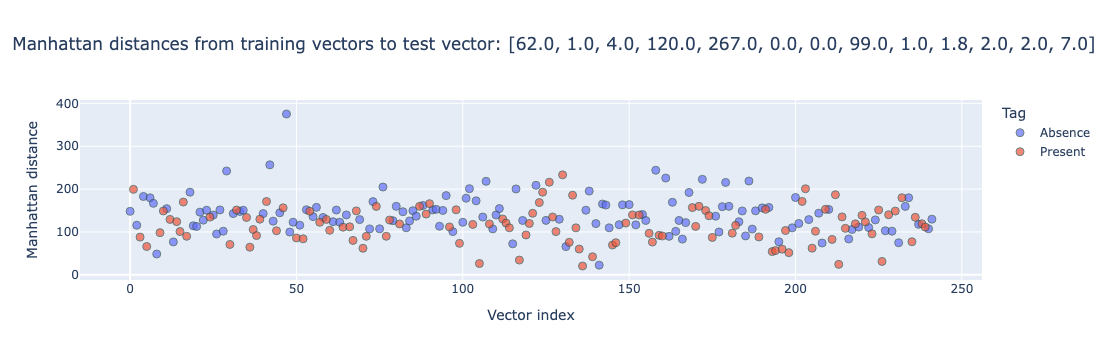

In [10]:
import plotly.express as px

training, training_labels = prepare_samples("training.txt")
test, _ = prepare_samples("test.txt")

manhattan_distances = [manhattan_distance(v, test[0]) for v in training]

fig = px.scatter(
    y=manhattan_distances,
    x=list(range(len(manhattan_distances))),
    color=training_labels,
    title=f"Manhattan distances from training vectors to test vector: {test[0]}",
    labels={
        'y': 'Manhattan distance',
        'x': 'Vector indecx',
        'color': 'Tag'
    }
)
fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    xaxis_title="Vector index",
    yaxis_title="Manhattan distance",
    title_x=0.5,
    legend_title_text='Tag'
)

fig.show()

In this figure I chose a random test vector, and computed the manhattan distance for each one of the training vectors respecting to it. With this, I found out that for this model, it will give a better accuracy score for more features we can have in the dataset, because the more features, the more difference will exist with different vectors, allowing to classify each records with better presicion

Graph 2: confusion matrix 

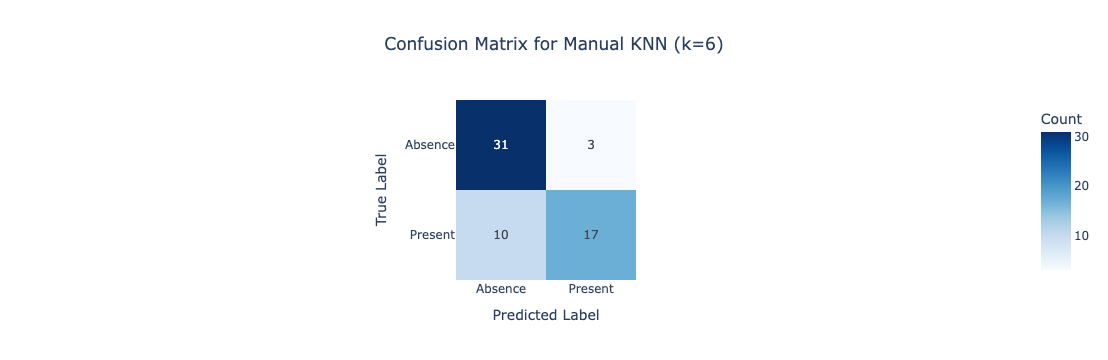

In [11]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
import pandas as pd

best_k = best_manual_k[0]
predictions = [classify(vector, training, training_labels, best_k) for vector in test]

labels = ["Absence", "Present"]
cm = confusion_matrix(test_labels, predictions, labels=labels)

fig = px.imshow(cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix for Manual KNN (k={best_k})")

fig.update_layout(title_x=0.5)
fig.show()

This matrix is a standard plot for exaluating the performance of a classification model. In this case, this KNN model only classifies between a binary tag, but in case more tags are added, this graph will not be elegible for determining the performance of the model

## KNN with scikit-learn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from typing import Tuple

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")


def knn_sklearn(training, training_labels, test, test_labels, k: int=5, p: int = 1) -> Tuple[int, str, float]:
    distances_formulas = {
        1: "Manhattan",
        2: "Euclidean",
    }
    
    # Create the model object
    knn = KNeighborsClassifier(n_neighbors=k, p=p)
    
    # Train the model
    knn.fit(training, training_labels)
    
    # Make predictions on the test data
    predictions = knn.predict(test)

    # Evaluate the model performance
    accuracy = accuracy_score(test_labels,predictions)

    return k, distances_formulas.get(p, "Minkowski"), accuracy

This function wraps the sklearn implementation for a KNN model. It is very straighforward, and allows a lot os suctomization, determining the k number, the vector similarity criteria, among other caracteristics

## Model accuracies with different k parameter (HW sklearn point 1)

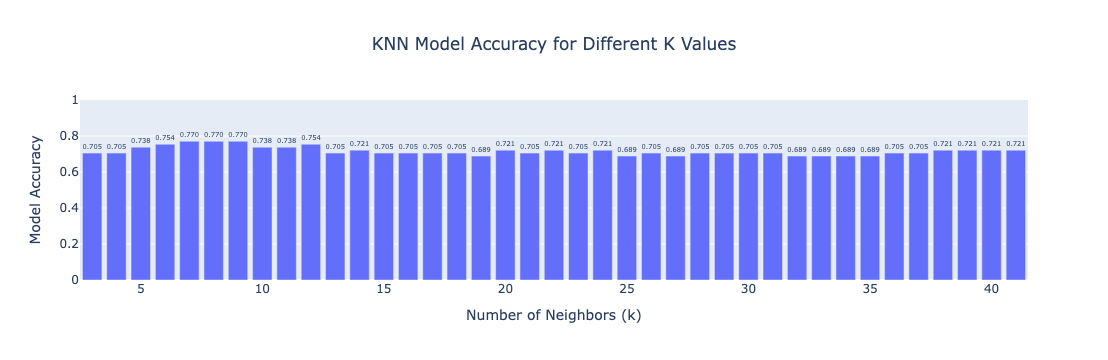

Best k value: 7


In [13]:
import plotly.express as px
import pandas as pd

different_k_results = []
for k in range(3, 42):
    different_k_results.append(knn_sklearn(training, training_labels, test, test_labels, k))

df_results = pd.DataFrame(different_k_results, columns=['k', 'distance_formula', 'accuracy'])

best_k_value = df_results.loc[df_results['accuracy'].idxmax()]['k']

fig = px.bar(
    data_frame=df_results,
    x='k',
    y='accuracy',
    title='KNN Model Accuracy for Different K Values',
    labels={
        'k': 'Number of Neighbors (k)',
        'accuracy': 'Model Accuracy'
    },
    text='accuracy'
)
fig.update_traces(
    texttemplate='%{text:.3f}',
    textposition='outside'
)
fig.update_layout(
    xaxis_title="Number of Neighbors (k)",
    yaxis_title="Model Accuracy",
    title_x=0.5,
    yaxis=dict(range=[0,1])
)

fig.show()

print(f"Best k value: {best_k_value}")

This script computes a KNN classification with different k numbers to plot them and to visually identify the range between performances with a varying k, and how much representative is this hyperparameter for the model performance

## Model accuracies with a different vector similarity criteria (HW sklearn point 2)

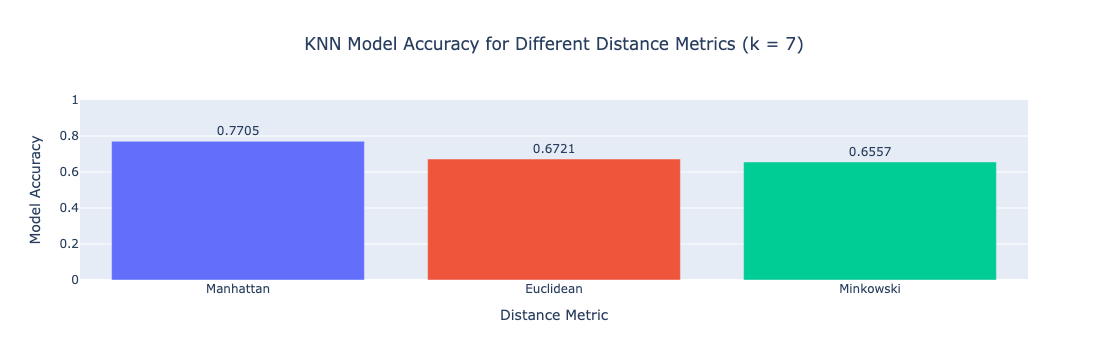

In [14]:
import plotly.express as px
import pandas as pd

different_similarity_results = []
for p in range(1,4):
    different_similarity_results.append(knn_sklearn(training, training_labels, test, test_labels, k=best_k_value, p=p))


df_similarity = pd.DataFrame(different_similarity_results, columns=['k', 'distance_formula', 'accuracy'])
fig = px.bar(
    data_frame=df_similarity,
    x='distance_formula',
    y='accuracy',
    color='distance_formula',
    title=f'KNN Model Accuracy for Different Distance Metrics (k = {best_k_value})',
    labels={
        'distance_formula': 'Distance Metric',
        'accuracy': 'Model Accuracy'
    },
    text='accuracy'
)

fig.update_traces(
    texttemplate='%{text:.4f}',
    textposition='outside'
)
fig.update_layout(
    xaxis_title="Distance Metric",
    yaxis_title="Model Accuracy",
    title_x=0.5,
    yaxis=dict(range=[0,1]),
    showlegend=False
)

fig.show()

This script performs a KNN with different vector similarity criteria, and plot the performance for each one of the models. THis allow us to analyze visually the impact of selecting the correct criteria to compare vectors

## Confusion matrix for sklearn KNN for HW point 7

0.7704918032786885


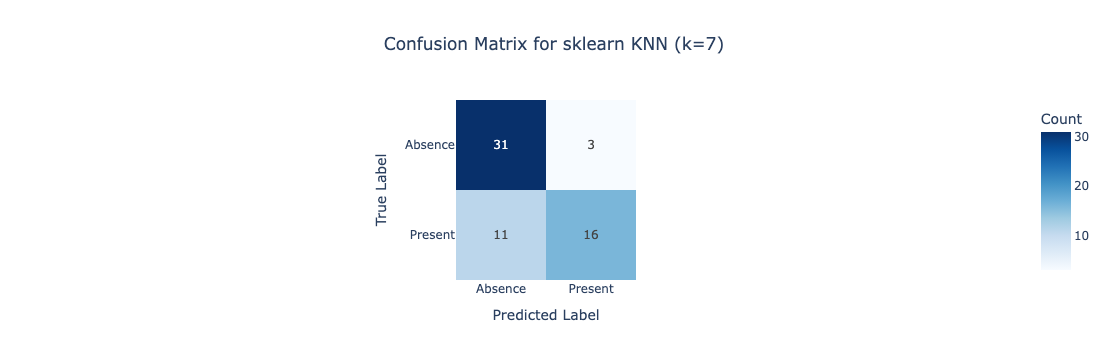

In [15]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

training, training_labels = prepare_samples("training.txt")
test, test_labels = prepare_samples("test.txt")

knn = KNeighborsClassifier(n_neighbors=best_k_value, p=1)
knn.fit(training, training_labels)
predictions = knn.predict(test)
accuracy = accuracy_score(test_labels,predictions)
print(accuracy)

labels = ["Absence", "Present"]
cm = confusion_matrix(test_labels, predictions, labels=labels)

fig = px.imshow(cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=labels,
                y=labels,
                text_auto=True,
                color_continuous_scale='Blues',
                title=f"Confusion Matrix for sklearn KNN (k={best_k_value})")

fig.update_layout(title_x=0.5)
fig.show()

## Insights and conclussion

With this activity I have been able to understand the core and the basics of the KNN machine learning algorithm for classification. I was able to identify how tuning and choosing the value for the hyperparameters makes different impact on the model performance. I have learned that for this model, as for others, is very important to tune and to select the correct hyperparameters for the dataset, because for every case the results will be different. It is very important to have this into consideration in order to acieve the best performance as possible.

Also, it is very important to make different tests, to don't be afraid of trying different combinations, scenarios, and possibilities for the model, in this way we will be able to reach the best model quality.

For example, I have learned that for this algorithm, the more features we can have in out training dataset, the easier for the similarity criteria to difference between vectors with different tags, therefore, the model performance will be better.

I also learned that manually imlementing this classification model is a good choice for small datasets, but as long as the dataset grows, a manual implementation is not possible because it is very inefficioent and memory consuming.

It is important to understand when it is a good desition to implement manually, and when is better to choose a production grade implementation such as the sklearn KNN model.

Finally, I learned that the model will not do magic if the dataset is incoherent and it is'nt well design, for acieving a good model performance, it is very important to perform a quality caracteristics engineering and to try with a different number of featrues to acieve the best results as possible.